### 2024-04-02 線種分類の手法をテスト

##### ▶データの補間方法3種類を実装

In [1]:
import numpy as np
import pandas as pd
import math
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns

# 有効数字用
import sigfig
from decimal import *

In [2]:
drawing_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0)

##### ①ストローク座標を補間

In [209]:
# 座標を補間する
def lerp_coord(x, y, sample_size):
    lerp_num = sample_size - len(x)
    lerp_x = x.copy()
    lerp_y = y.copy()
    
    for i in range(lerp_num):
        max_len = 0
        max_len_index = 0 # max_len_index の手前に補間座標を追加する
        for j in range(1, len(lerp_x)):
            segment_len = math.sqrt((lerp_x[j] - lerp_x[j-1])**2 + (lerp_y[j] - lerp_y[j-1])**2)
            max_len_index = j if max_len < segment_len else max_len_index
            max_len = segment_len if max_len < segment_len else max_len
        
        center_x = round((lerp_x[max_len_index] + lerp_x[max_len_index-1]) / 2, 4)
        center_y = round((lerp_y[max_len_index] + lerp_y[max_len_index-1]) / 2, 4)
        lerp_x.insert(max_len_index, center_x)
        lerp_y.insert(max_len_index, center_y)
        
    return lerp_x, lerp_y

# ドローイング情報を取得する
def get_drawing_data(url, drawing_id, rotate_type, times):
    class DrawingData():
        def __init__(self, url, drawing_id, rotate_type, times):
            self.CANVAS_HEIGHT = 297
            self.CANVAS_WIDTH = 420
            self.MAX_POINT = 943
            self.NORM_DIVISOR = 3
            self.columns = [ 'time', 'alpha', 'max_points', 'ptx_anoto', 'pty_anoto', 'shape_str',
                        'pressure_style', 'len_mm_acc', 'len_anoto', 'pressure_avg', 'shape_int']
            self.BIN_HEIGHT = 420
            self.BIN_WIDTH = 420
            
            self.df_org = None
            self.df_mm = None
            
            self.url = url
            self.drawing_id = drawing_id
            self.rotate_type = rotate_type
            self.times = times
            
            # urlからデータを作成
            self.get_df(self.url)
            self.conv_str_to_coord()

            ################################
            
        # URLからデータフレームを取得 & ストローク長の列を追加
        def get_df(self, url):
            content = requests.get(url, auth=('19t2003a', 'ireneRED77')).content
            df = pd.read_table(io.StringIO(content.decode('utf-8')), header = None)
            df.columns = self.columns
            st_len_mm = [l*0.3 for l in df['len_anoto']]
            df['len_mm'] = st_len_mm
            # ストローク固有のidを付与
            df_reindex = df.reset_index()
            df_reindex = df_reindex.rename(columns={'index': 'stroke_id'})
            
            # ドローイングidの列を追加
            df_reindex['drawing_id'] = [self.drawing_id for i in range(len(df_reindex))]
            # 回数の列を追加
            df_reindex['times'] = [self.times for i in range(len(df_reindex))]
            
            self.df_org = df_reindex.copy()
            
        # 文字列座標データをリストに変換 & anotoから普通座標に変換
        def conv_str_to_coord(self):
            df = self.df_org.copy()
            x_list = []
            y_list = []
            for str_x, str_y in zip(df['ptx_anoto'], df['pty_anoto']):
                x_list.append([float(x)*0.3 for x in str_x.split(',')])
                y_list.append([float(y)*0.3 for y in str_y.split(',')])
            df['ptx_mm'] = x_list
            df['pty_mm'] = y_list
            self.df_mm = df
            
            
    data = DrawingData(url, drawing_id, rotate_type, times)
    
    return data.df_mm

# 座標数をインデックス等間隔でリサンプリングする
def resample_coord(x, y, resample_size):
    # リサンプリングする要素のインデックスを取得
    org_size = len(x)
    resample_index = []
    space  = (org_size - 1) // (resample_size - 1)       # リサンプリングの間隔
    rest_size = (org_size - 1) % (resample_size - 1)
    index = 0
    for i in range(resample_size):
        resample_index.append(index)
        index += space
        if rest_size > 0:
            index += 1
            rest_size -= 1
            
    # インデックスをもとにリストから要素を抽出
    resample_x = [val for i, val in enumerate(x) if i in resample_index]
    resample_y = [val for i, val in enumerate(y) if i in resample_index]

    return resample_x, resample_y

# 隣合う線分どうしを合計し，

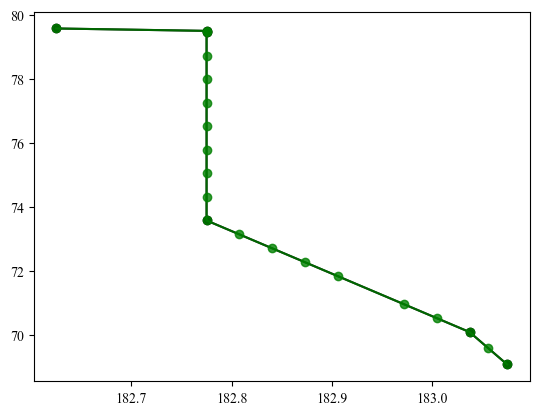

In [213]:
num = 1
url, drawing_id, rotate_type, times = drawing_info['url'][num], drawing_info['drawing_id'][num], drawing_info['rotate_type'][num], drawing_info['times'][num]
df = get_drawing_data(url, drawing_id, rotate_type, times)

num = 140
lerp_size = 20
resample_size = 15

x, y = df['ptx_mm'][num], df['pty_mm'][num]
plt.plot(x, y, marker='.', markersize=12, color='black')

lerp_x, lerp_y = lerp_coord(x, y, lerp_size)
plt.plot(lerp_x, lerp_y, marker='.', markersize=12, color='green', alpha=0.8)

resample_x, resample_y = resample_coord(lerp_x, lerp_y, resample_size)
# plt.plot(resample_x, resample_y, marker='.', markersize=12, color='red', alpha=0.5)
plt.show()
plt.close()

In [38]:
def get_downsampled_coord_by_length(x, y, sample_size):
    org_size = len(x)
    rest_size = sample_size - 2
    space_size = sample_size - 1
    # ストロークの座標間のすべての線分の長さを格納したリスト
    segment_st_length = [math.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2) for i in range(1, len(x))]
    # ストロークの長さ
    st_length = sum(segment_st_length)
    # ストロークの長さを間隔の数で割った長さ
    space_length = st_length / space_size
    space_lengths = [space_length * i for i in range(1, rest_size+1)]
    
    # 抽出する座標を計算する
    current_len_acc = 0
    previous_len_acc = 0
    sampled_xs = []
    sampled_ys = []
    
    lerp_xs = x.copy()
    lerp_ys = y.copy()
    is_org = [True for i in range(len(x))]
    
    sample_cnt = 0
    for sl in space_lengths:
        current_len_acc = 0
        previous_len_acc = 0
        for i in range(1, len(x)):
            current_len = math.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2)
            current_len_acc += current_len
            
            if sl <= current_len_acc:
                sl_carry_over = sl - previous_len_acc
                sampled_x = x[i-1] + (sl_carry_over * (x[i] - x[i-1])) / current_len
                sampled_y = y[i-1] + (sl_carry_over * (y[i] - y[i-1])) / current_len
                sampled_xs.append(sampled_x)
                sampled_ys.append(sampled_y)
                
                # 検算用
                lerp_xs.insert(i+sample_cnt, sampled_x)
                lerp_ys.insert(i+sample_cnt, sampled_y)
                is_org.insert(i+sample_cnt, False)
                break
            else:
                pass
            previous_len_acc += current_len
        # 検算用
        sample_cnt += 1
            
    
    # 元のリストの最初と最後の要素を追加する
    sampled_xs.insert(0, x[0])
    sampled_xs.append(x[-1])
    sampled_ys.insert(0, y[0])
    sampled_ys.append(y[-1])
    
    return  sampled_xs, sampled_ys, lerp_xs, lerp_ys, is_org

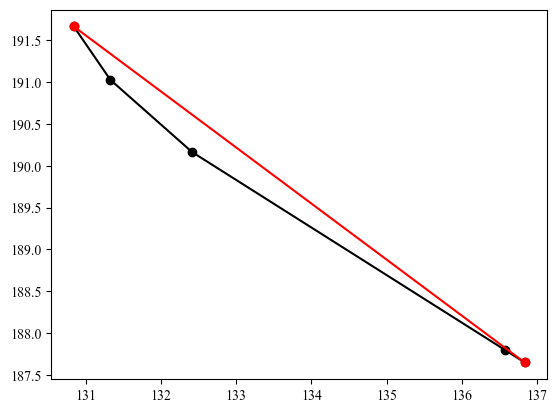

In [73]:
num = 70
url, drawing_id, rotate_type, times = drawing_info['url'][num], drawing_info['drawing_id'][num], drawing_info['rotate_type'][num], drawing_info['times'][num]
df = get_drawing_data(url, drawing_id, rotate_type, times)

num = 140
lerp_size = 15
resample_size = 15

x, y = df['ptx_mm'][num], df['pty_mm'][num]
sx, sy, lx, ly, is_orgs = get_downsampled_coord_by_length(x, y, 2)

# 用紙のサイズの大きさの変更
# SCALE = 0.1
# plt.rcParams['font.family'] = 'Times New Roman'
# STROKE_COLOR = 'black'
# FACE_COLOR = 'white'
# STROKE_WIDTH = 0.5
# FIG_SIZE = (420*SCALE, 297*SCALE)
# fig, ax = plt.subplots(facecolor=FACE_COLOR, figsize=(FIG_SIZE[0],FIG_SIZE[1]))
# plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, 
#                 bottom=False, left=False, right=False, top=False)
# ax.set_xlim([0, 420])    # x方向の描画範囲を指定
# ax.set_ylim([0, 297])    # y方向の描画範囲を指定
# ax.set_facecolor(FACE_COLOR)

# x, y = df['ptx_mm'][num], df['pty_mm'][num]

plt.plot(x, y, marker='.', markersize=12, color='black')
# plt.plot(x[0], y[0], marker='.', markersize=12, color='green')

plt.plot(sx, sy, marker='.', markersize=12, color='red')
# plt.scatter(sx, sy, marker='.', color='red')


In [74]:
segment_len = 0
for i in range(1, len(is_orgs)):
    segment_len += math.sqrt((lx[i] - lx[i-1])**2 + (ly[i] - ly[i-1])**2)
    if is_orgs[i]:
        pass
    else:
        print(segment_len)
        segment_len = 0
print(segment_len)

7.279087037665144


In [190]:
# 隣合う座標どうしでコサイン類似度が高い場所から点を取り除く
def get_downsampled_coord_by_cossim(x, y, sample_size):
    # コサイン類似度を計算する
    def calc_cos_sim(v1, v2):
        if (np.linalg.norm(v1) * np.linalg.norm(v2)) == 0:
            print('------------ exception -------------')
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    
    # 取り除く座標の数
    remove_size = len(x) - sample_size
    sampled_x = x.copy()
    sampled_y = y.copy()
    for i in range(remove_size):
        cos_sims = []
        for j in range(2, len(sampled_x)):
            first_vec = np.array([sampled_x[j-1] - sampled_x[j-2], sampled_y[j-1] - sampled_y[j-2]])
            second_vec = np.array([sampled_x[j] - sampled_x[j-1], sampled_y[j] - sampled_y[j-1]])
            cos_sims.append(calc_cos_sim(first_vec, second_vec))
        # コサイン類似度の最大値のインデックスを取得する
        # コサイン類似度の最大値が複数ある場合は最初に見つかった最大値のインデックスを取得する
        remove_index = cos_sims.index(max(cos_sims)) + 1
        sampled_x.pop(remove_index)
        sampled_y.pop(remove_index)
        
    
    return sampled_x, sampled_y

In [206]:
def get_downsampled_coord_by_cossim_all(x, y, sample_size):
    # コサイン類似度を計算する
    def calc_cos_sim(v1, v2):
        if (np.linalg.norm(v1) * np.linalg.norm(v2)) == 0:
            print('------------ exception -------------')
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    
    # 取り除く座標の数
    cos_sims = []
    for j in range(2, len(x)):
        first_vec = np.array([x[j-1] - x[j-2], y[j-1] - y[j-2]])
        second_vec = np.array([x[j] - x[j-1], y[j] - y[j-1]])
        cos_sims.append(calc_cos_sim(first_vec, second_vec))
    
    # コサイン類似度の上位のみを除外する
    is_cossim_higher = [False for i in range(len(cos_sims))]
    for i in range(sample_size-2):
        # 昇順に並べ替えたリスト
        sorted_cossims = sorted(cos_sims, reverse=False)
        # i番目に小さい値のインデックス
        i_min = sorted_cossims[i]
        extract_index = cos_sims.index(i_min)
        is_cossim_higher[extract_index] = True

        
    sampled_x = [x[i+1] for i in range(len(cos_sims)) if is_cossim_higher[i]]
    sampled_y = [y[i+1] for i in range(len(cos_sims)) if is_cossim_higher[i]]
    sampled_x.insert(0, x[0])
    sampled_x.append(x[-1])
    sampled_y.insert(0, y[0])
    sampled_y.append(y[-1])
    return sampled_x, sampled_y

-0.9609069544270525
-0.8581129235370645
0.6616216370868424
0.8944271909999012
0.9570244044334728
0.9780785919047312
0.992277876713668
0.9950600226067574


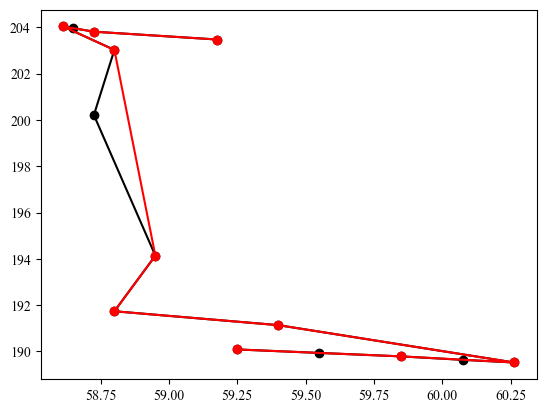

In [208]:
num = 500
url, drawing_id, rotate_type, times = drawing_info['url'][num], drawing_info['drawing_id'][num], drawing_info['rotate_type'][num], drawing_info['times'][num]
df = get_drawing_data(url, drawing_id, rotate_type, times)

stroke_num = 30

sample_size = 10

x, y = df['ptx_mm'][stroke_num], df['pty_mm'][stroke_num]
cos_x, cos_y, = get_downsampled_coord_by_cossim_all(x, y, sample_size)
plt.plot(x, y, marker='.', markersize=12, color='black')
# plt.plot(x[0], y[0], marker='.', markersize=12, color='orange')
plt.plot(cos_x, cos_y, marker='.', markersize=12, color='red')